In [1]:
import os
from pathlib import Path
from random import choice, seed, sample
from typing import List, Tuple, cast

import numpy as np
from cv2 import COLOR_RGB2GRAY, THRESH_BINARY, THRESH_OTSU, cvtColor, threshold
from matplotlib.pyplot import (  # type: ignore
    Figure,
    axis,
    imshow,
    show,
    subplots,
    title,
)
from numpy import ndarray
from PIL import Image
from PIL.Image import open as open_image
from pytesseract import image_to_string, pytesseract
from torch.cuda import is_available
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder  # type: ignore
from torchvision.transforms import (
    Compose,
    Grayscale,
    Normalize,
    Resize,
    ToPILImage,
    ToTensor,
)

In [2]:
import sys


DEVICE = "cuda" if is_available() else "cpu"

if sys.platform == "win32":
    pytesseract.tesseract_cmd = Path("D:\\") / "Tesseract-OCR" / "tesseract.exe"
    print(pytesseract.tesseract_cmd)

In [3]:
path = Path.cwd() / "data"

Random Image Path : /run/media/harbingeroftheend/DATA/Projects/NotesAI/data/658/r03-007.png
Image Class : 658
Image Height : 3542
Image Width : 2479


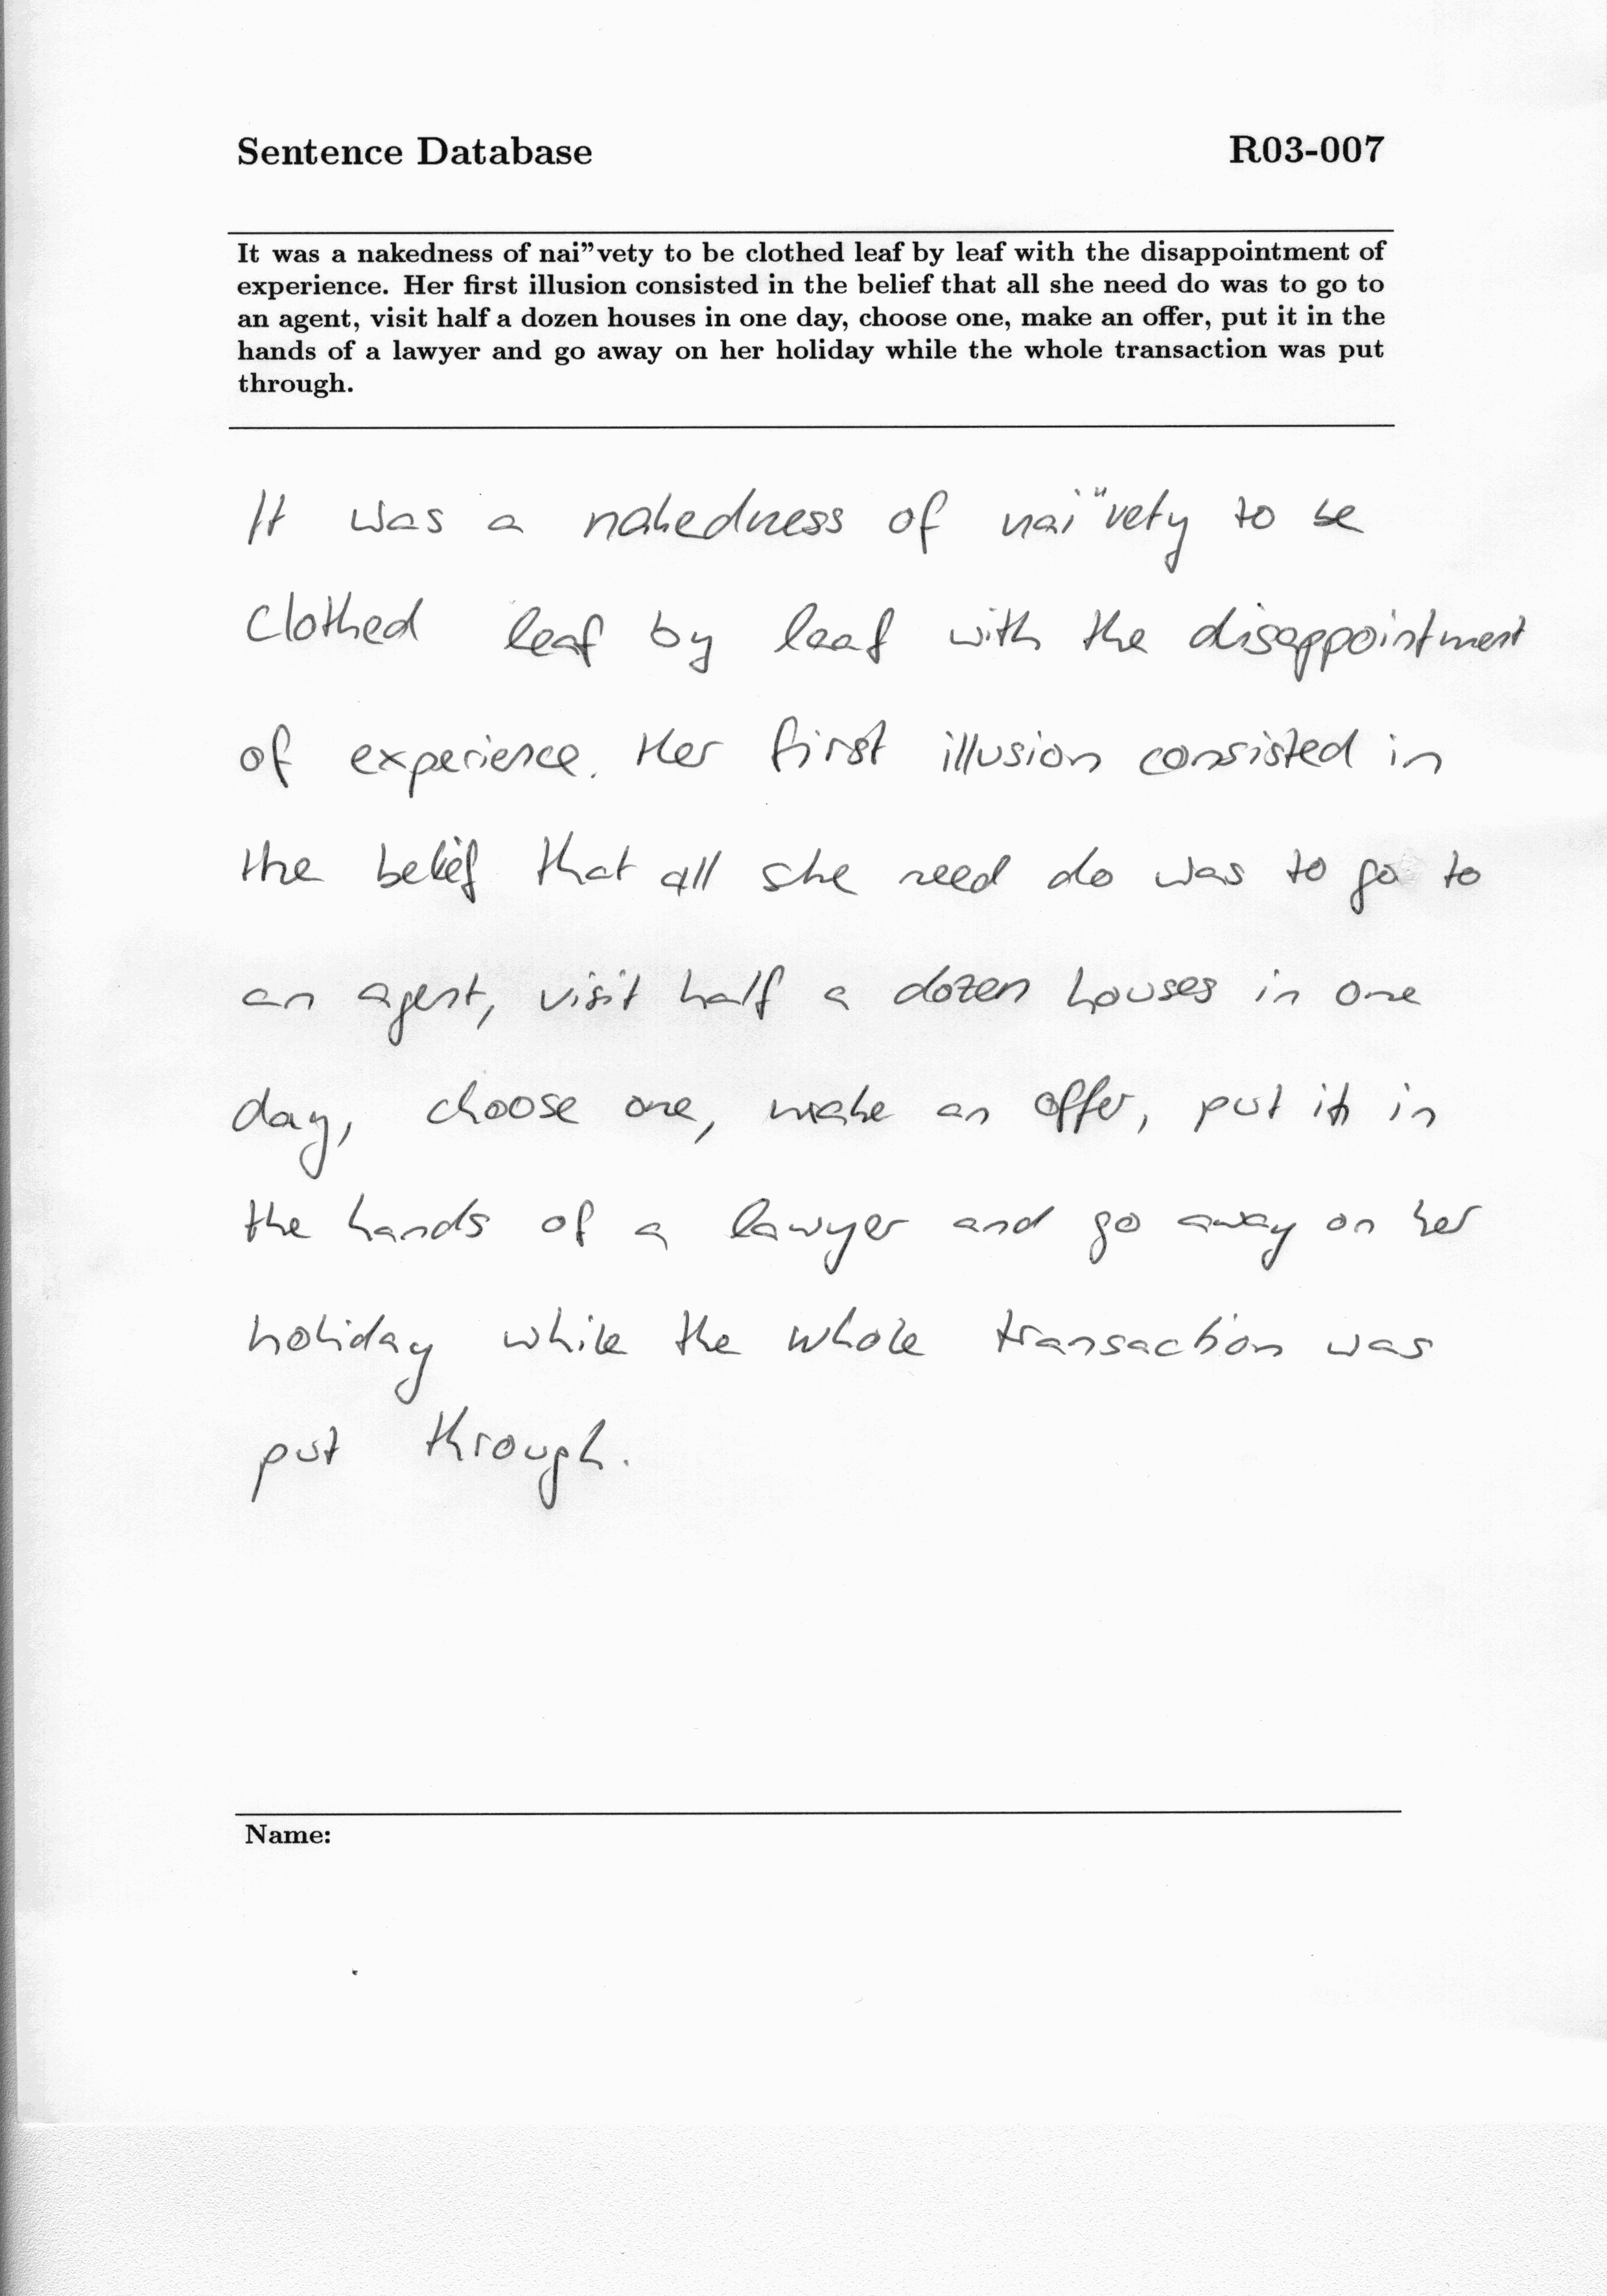

In [4]:
image_list = [*path.glob("*/*")]
image_path = choice(image_list)
image = open_image(image_path)

print(f"Random Image Path : {image_path}")
print(f"Image Class : {image_path.parent.stem}")
print(f"Image Height : {image.height}")
print(f"Image Width : {image.width}")
image

In [5]:
transforms = Compose(
    [
        Grayscale(num_output_channels=1),
        Resize((128, 128)),
        ToTensor(),
        Normalize((0.5,), (0.5,)),
    ]
)

transforms

Compose(
    Grayscale(num_output_channels=1)
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)

In [6]:
def plot_transformed_image(
    image_paths: List[Path], transform: Compose, n: int = 3, r_seed: int = 42
):
    seed(r_seed)
    random_image_paths = sample(image_paths, k=n)
    for image_path in random_image_paths:
        with open_image(image_path) as f:
            fig, ax = cast(Tuple[Figure, ndarray], subplots(1, 2))  # type: ignore
            print(type(fig), type(ax))  # type: ignore
            ax[0].imshow(f)
            ax[0].set_title(f"Original Size : {f.size}")
            ax[0].axis(False)
            transformed_image = transform(f).permute(1, 2, 0)  # type: ignore
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nsize : {transformed_image.shape}")  # type: ignore
            ax[1].axis(False)

            fig.suptitle(f"Class : {image_path.parent.stem}", fontsize=16)  # type: ignore

<class 'matplotlib.figure.Figure'> <class 'numpy.ndarray'>
<class 'matplotlib.figure.Figure'> <class 'numpy.ndarray'>
<class 'matplotlib.figure.Figure'> <class 'numpy.ndarray'>


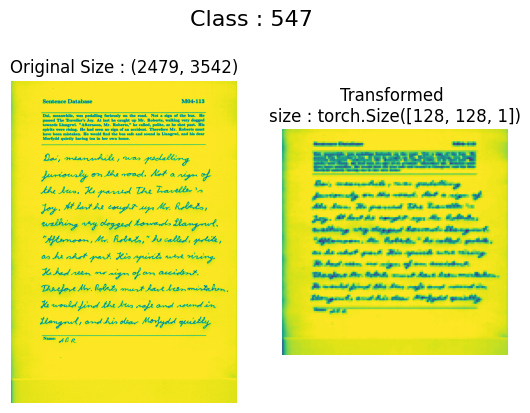

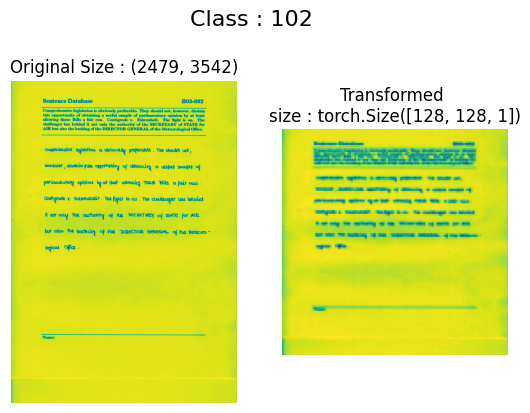

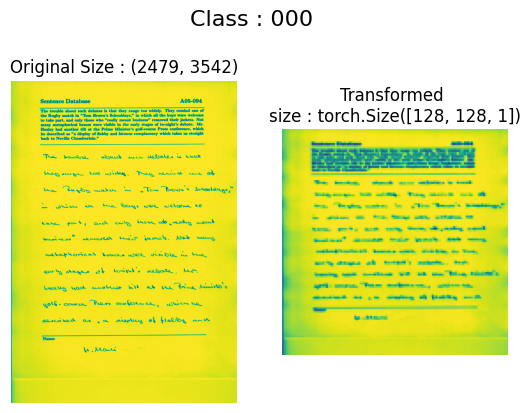

In [7]:
plot_transformed_image(image_list, transforms)

In [8]:
train_data = ImageFolder(
    root=path.as_posix(),
    transform=transforms,
    target_transform=None,
)
train_data

Dataset ImageFolder
    Number of datapoints: 1539
    Root location: /run/media/harbingeroftheend/DATA/Projects/NotesAI/data
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [9]:
val_size = int(0.2 * len(train_data))
train_size = len(train_data) - val_size
train_subset, val_subset = random_split(
    train_data,
    [
        train_size,
        val_size,
    ],
)

In [10]:
train_dataloader = DataLoader(
    dataset=train_subset, batch_size=32, shuffle=True, num_workers=os.cpu_count()
)
val_dataloader = DataLoader(
    dataset=val_subset, batch_size=32, shuffle=False, num_workers=os.cpu_count()
)

train_dataloader, val_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fedb8dd0950>,
 <torch.utils.data.dataloader.DataLoader at 0x7fedb8da0410>)

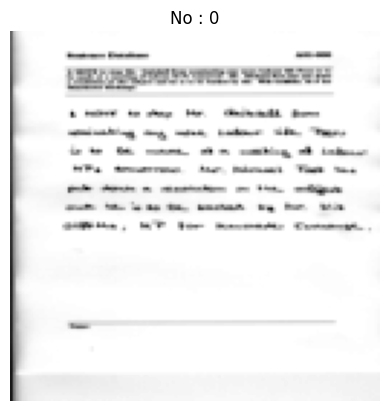

In [11]:
image, label = train_data[0]
imshow(ToPILImage()(image), cmap="gray")
title(f"No : {label}")
axis(False)
show()

In [12]:
def preprocess_img(img):
    if isinstance(img, str):
        img = Image.open(img)
    if img.mode != "RGB":
        img = img.convert("RGB")
    img_arr = np.array(img)
    gray_img = cvtColor(img_arr, COLOR_RGB2GRAY)
    _, thresh_image = threshold(gray_img, 0, 255, THRESH_BINARY + THRESH_OTSU)
    return thresh_image


def extract_text(img):
    preprocessed_img = preprocess_img(img)
    pil_image = Image.fromarray(preprocessed_img)
    text = image_to_string(pil_image, config="--psm 11")
    return text.strip()


In [13]:
img_path_list = [*path.glob("*/*")]
random_img_path = choice(img_path_list)
img = Image.open(random_img_path)
extracted_txt = extract_text(img)
print(f"Extracted Image : {extracted_txt}")


Extracted Image : Sentence Database

RO03-115

Much more spacious than that poky little cottage, which wasn’t a bit practical really,

the reception room was too small when divided and too big when not.

Hada migee Bpackou nan Yast poku xk DO ;

Anco Wasn't 2 Bt IANO. teat, ne

Leap Cou

YS Wo Sraa ran

i d ss ai

Ayd Da OL

py TU rT .

Name:

\

und

tree


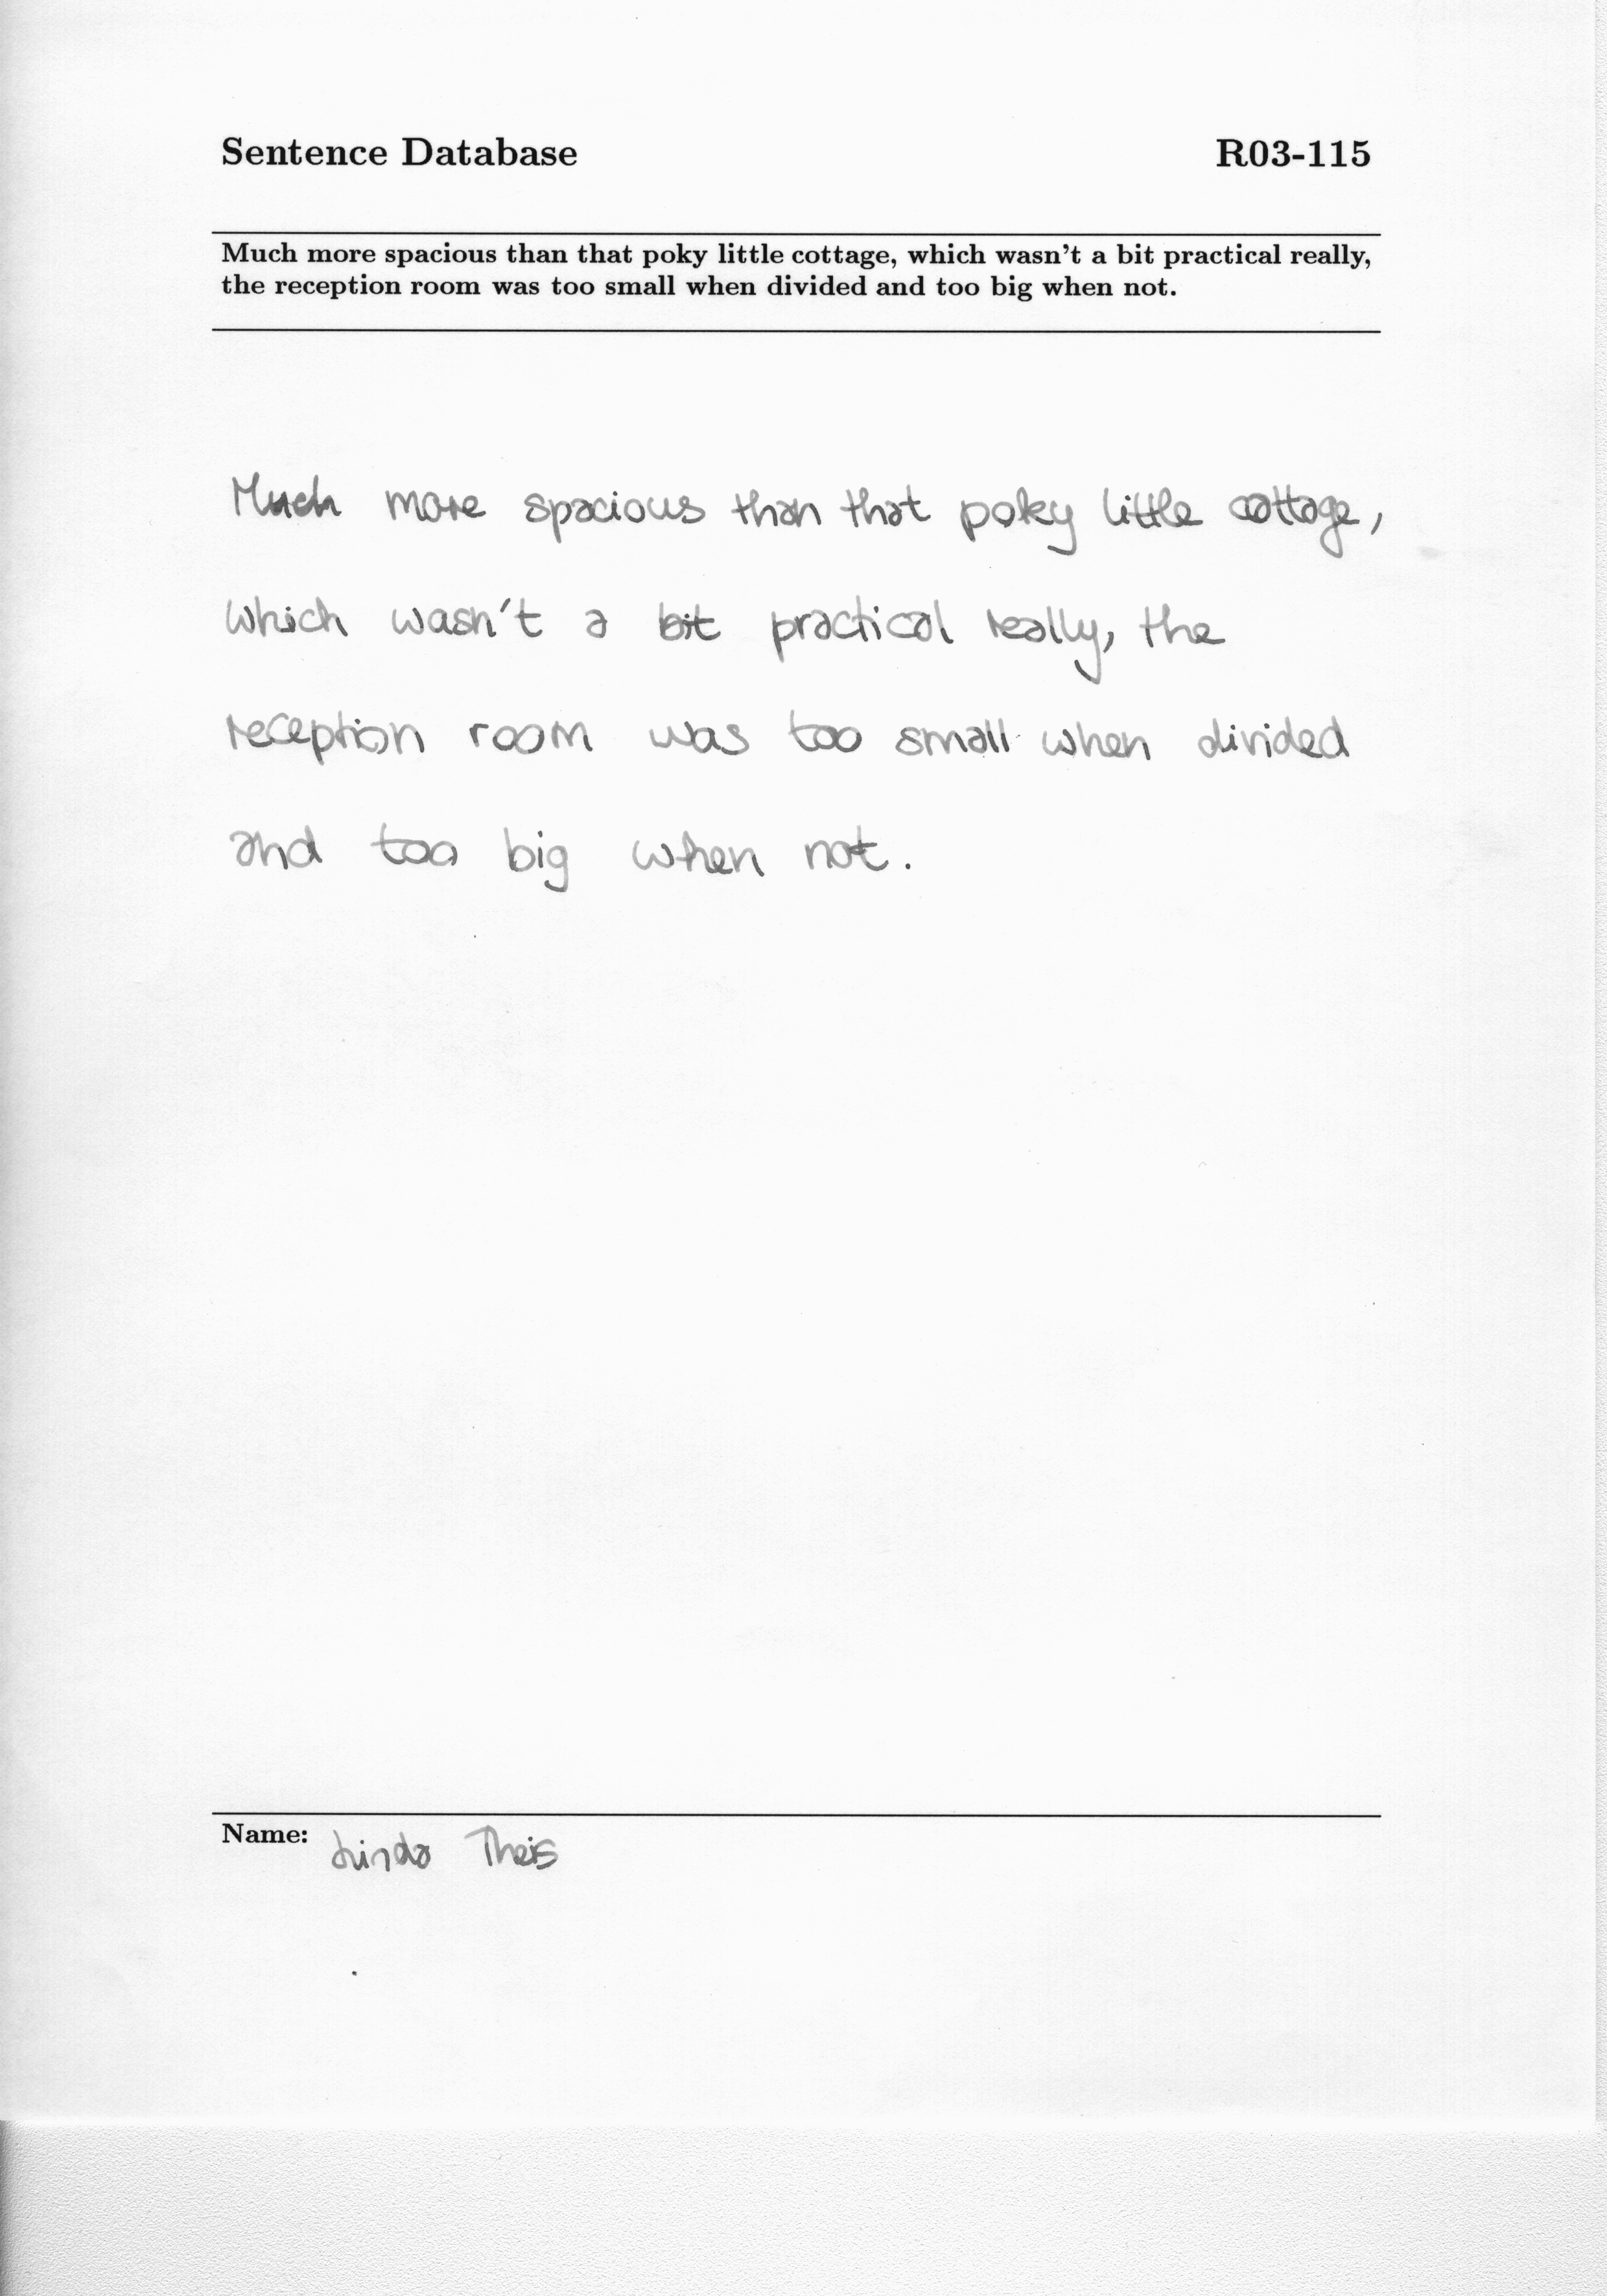

In [14]:
img

In [15]:
from torch import zeros
from torch.nn import Module, LSTM, Linear
from torch.optim import Optimizer


class HandwritingTextRecognizer(Module):
    def __init__(
        self,
        input_size: int,
        hidden_units: int,
        output_shape: int,
        num_layers: int = 1,
    ) -> None:
        super().__init__()
        self.hidden_units = hidden_units
        self.num_layers = num_layers
        self.rnn = LSTM(
            input_size,
            self.hidden_units,
            self.num_layers,
            batch_first=True,
        )
        self.fc = Linear(
            hidden_units,
            output_shape,
        )

    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size, device):
        return (
            zeros(self.num_layers, batch_size, self.hidden_units, device=device),
            zeros(self.num_layers, batch_size, self.hidden_units, device=device),
        )

In [16]:
from torch import device


def train_step(
    model: HandwritingTextRecognizer,
    dataloader: DataLoader,
    loss_fn: Module,
    optim: Optimizer,
    device: device,
):
    model.train()
    train_loss = 0.0

    for x, _ in dataloader:
        x = x.to(device)

        batch_size, channels, height, width = x.size()
        x = x.view(batch_size, -1)
        x = x.unsqueeze(1)

        hidden = model.init_hidden(batch_size, device)
        optim.zero_grad()

        outputs, _ = model(x, hidden)
        targets = x.view(batch_size, -1)
        loss = loss_fn(outputs, targets)

        loss.backward()
        optim.step()

        train_loss += loss.item()

    return train_loss / len(dataloader)

In [17]:
from torch import inference_mode


def test_step(
    model: HandwritingTextRecognizer,
    dataloader: DataLoader,
    loss_fn: Module,
    device: device,
):
    model.eval()
    test_loss = 0.0
    with inference_mode():
        for x, _ in dataloader:
            x = x.to(device)

            batch_size, channels, height, width = x.size()
            x = x.view(batch_size, -1)
            x = x.unsqueeze(1)

            hidden = model.init_hidden(x.size(0), device)

            outputs, _ = model(x, hidden)

            outputs = outputs.squeeze(1)
            targets = x.view(x.size(0), -1)

            loss = loss_fn(outputs, targets)
            test_loss += loss.item()
    return test_loss / len(dataloader)


In [18]:
def train(
    model: HandwritingTextRecognizer,
    train_dataloader: DataLoader,
    val_dataloader: DataLoader,
    optimizer: Optimizer,
    loss_fn: Module,
    device: device,
    epochs: int = 5,
):
    model.to(device)
    results = {"train_loss": [], "val_loss": []}

    for epoch in range(epochs):
        train_loss = train_step(model, train_dataloader, loss_fn, optimizer, device)
        val_loss = test_step(model, val_dataloader, loss_fn, device)

        print(
            f"Epoch: {epoch + 1} | train_loss: {train_loss:.3f} | val_loss: {val_loss:.3f}"
        )
        results["train_loss"].append(train_loss)
        results["val_loss"].append(val_loss)

    return results

In [20]:
from torch.nn import MSELoss
from torch.optim import Adam
from torch import manual_seed
from torch.cuda import manual_seed as cuda_manual_seed
from time import perf_counter


input_shape = 128 * 128
output_shape = input_shape
hidden_units = 256
num_layers = 2
model = HandwritingTextRecognizer(
    input_size=input_shape,
    output_shape=output_shape,
    hidden_units=hidden_units,
    num_layers=num_layers,
)
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=0.002)
# manual_seed(42)
# cuda_manual_seed(42)

start_time = perf_counter()

model_results = train(
    model, train_dataloader, val_dataloader, optimizer, loss_fn, epochs=20, device=DEVICE,
)

end_time = perf_counter()

print(f"Total Training Time : {end_time - start_time:.3f}seconds")

Epoch: 1 | train_loss: 0.122 | val_loss: 0.015
Epoch: 2 | train_loss: 0.010 | val_loss: 0.009
Epoch: 3 | train_loss: 0.009 | val_loss: 0.009
Epoch: 4 | train_loss: 0.009 | val_loss: 0.009
Epoch: 5 | train_loss: 0.009 | val_loss: 0.009
Epoch: 6 | train_loss: 0.009 | val_loss: 0.009
Epoch: 7 | train_loss: 0.009 | val_loss: 0.009
Epoch: 8 | train_loss: 0.009 | val_loss: 0.009
Epoch: 9 | train_loss: 0.009 | val_loss: 0.009
Epoch: 10 | train_loss: 0.009 | val_loss: 0.009
Epoch: 11 | train_loss: 0.009 | val_loss: 0.009
Epoch: 12 | train_loss: 0.009 | val_loss: 0.010
Epoch: 13 | train_loss: 0.009 | val_loss: 0.010
Epoch: 14 | train_loss: 0.009 | val_loss: 0.009
Epoch: 15 | train_loss: 0.009 | val_loss: 0.009
Epoch: 16 | train_loss: 0.009 | val_loss: 0.009
Epoch: 17 | train_loss: 0.009 | val_loss: 0.010
Epoch: 18 | train_loss: 0.009 | val_loss: 0.009
Epoch: 19 | train_loss: 0.009 | val_loss: 0.009
Epoch: 20 | train_loss: 0.009 | val_loss: 0.009
Total Training Time : 623.920seconds


In [21]:
from torch import multinomial
import torch.nn.functional as F


def sample(predictions, temperature=1.0):
    predictions = predictions / temperature
    probabilities = F.softmax(predictions, dim=-1)
    return multinomial(probabilities, 1).item()


In [22]:
from torch import cat, float32, no_grad, tensor


def generate_text(model, seed_text, max_length, device, temperature=1.0):
    model.eval()
    generated_text = seed_text

    # Converting Textv into tensor
    seed_tensor = (
        tensor([ord(char) for char in seed_text], dtype=float32).unsqueeze(0).to(device)
    )

    if seed_tensor.size(-1) < 16384:
        padding_size = 16384 - seed_tensor.size(-1)
        seed_tensor = F.pad(seed_tensor, (0, padding_size), "constant", 0)
    else:
        seed_tensor = seed_tensor[:, :16384]

    seed_tensor = seed_tensor.unsqueeze(1)

    hidden = model.init_hidden(seed_tensor.size(0), device)

    print(f"Initial seed_tensor shape: {seed_tensor.shape}")
    print(f"Initial Hidden state shape: {hidden[0].shape}, {hidden[1].shape}")

    with no_grad():
        for _ in range(max_length):
            output, hidden = model(seed_tensor, hidden)

            output = output.squeeze(1)

            predicted_char_index = sample(output, temperature)
            predicted_char = chr(predicted_char_index)
            generated_text += predicted_char

            # Update seed tensor with the new character
            new_char_tensor = (
                tensor([ord(predicted_char)], dtype=float32).unsqueeze(0).to(device)
            )
            new_char_tensor = F.pad(
                new_char_tensor, (0, 16384 - new_char_tensor.size(-1)), "constant", 0
            )
            new_char_tensor = new_char_tensor.unsqueeze(1)

            # Slide the window to include the new character
            seed_tensor = cat((seed_tensor[:, 1:, :], new_char_tensor), dim=1)

    return generated_text


In [23]:
seed_text = extracted_txt
max_length = 200
temperature = 0.8
model.to(DEVICE)

generated_text = generate_text(model, seed_text, max_length, DEVICE)
print(f"Generated text: {generated_text}")


Initial seed_tensor shape: torch.Size([1, 1, 16384])
Initial Hidden state shape: torch.Size([2, 1, 256]), torch.Size([2, 1, 256])
Generated text: Sentence Database

RO03-115

Much more spacious than that poky little cottage, which wasn’t a bit practical really,

the reception room was too small when divided and too big when not.

Hada migee Bpackou nan Yast poku xk DO ;

Anco Wasn't 2 Bt IANO. teat, ne

Leap Cou

YS Wo Sraa ran

i d ss ai

Ayd Da OL

py TU rT .

Name:

\

und

treeⓜੀ༶㜗ՙᎃ⟀ώⴕᘦ㽞೟ሯआᨥጣ⑵㦖ဇ࿚㶭㭦Ţⷧᣬ⼢㑼㻺㟩ノ㑍ᚸ١ㄟↆẘ㢁ㄴ˝ۯඉ㽦˳ᶏ⸬ℛⷮ㗩཭㥣㕝ᇔᷝɧ៓ࡩ¤㈱፽ป㎱ⵇᅘげ៼㊵ᰕᾗኛ㠖ጉ⑅たⰯ㑡պ㸯㝄༙᪀ⰱ0㐵⠻ցඇⵠ࢞ᇅ⁫㨇ḵ⩂ߢ㈰ㅲ⨡⩯㮁Ⱈ㰐㽃㡴ㇱ⼇⇷㌪㟗៨⨼՞ራ⏡⯋㤎ᄬጭᨹ㮭ᾐᆶࡶ਷Ѱе᭒⚙₈㊘㎃ऊ㏖O܎ğ㷘ᣥ≜㍂⎉๝ᴬ⯐₭ࡿŧԍᔩṧᛪ⣹㐎ࡾ⾮㎇㚩ᩀ㐂Ƀ㲯ዏᛶ㺨⽝ស‹ㄾⶴ⻳≥⏤㈊ᖜ⫲᭎ᢋΤ╿♬ⲳफ़ᢹ㈐㟙⒟㓦╕㍌Ƞ㏆ह㌎㓲ϒᕖ㞃㦅ᢛ㮄㾼


In [27]:
from torch import save

save(model, "handwriting_text_recognizer.pth")